In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to c:\users\public\documents\estsoft\creatortemp\pip-install-21x4q7u9\pytorch-tabnet_f8dec3005cca4ac389b8b1b525ba8e03
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pytorch-tabnet: filename=pytorch_tabnet-3.1.1-py3-none-any.whl size=39572 sha256=6ba09354756886ed05f431e03dd96c2ffc73e4ac214d5f23d09a8ca67c55bb64
  Stored in directory: C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-ephem-wheel-cache-j4dmr5ri\wheels\a6\8e\aa\6f5ef6a2e389c8b5f7ea1c74bbb03ece8773b03c2b8955c334
Successfully built pytorch-tabnet


  Running command git clone -q https://github.com/dreamquark-ai/tabnet.git 'C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-install-21x4q7u9\pytorch-tabnet_f8dec3005cca4ac389b8b1b525ba8e03'


(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64
gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         ------------

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/18 [00:00<?, ?it/s]

gender 2
Column gender does not exist in test set
car 2
Column car does not exist in test set
reality 2
Column reality does not exist in test set
child_num 3
Column child_num does not exist in test set
income_total 7
Column income_total does not exist in test set
income_type 5
Column income_type does not exist in test set
edu_type 5
Column edu_type does not exist in test set
family_type 5
Column family_type does not exist in test set
house_type 6
Column house_type does not exist in test set
FLAG_MOBIL 1
Column FLAG_MOBIL does not exist in test set
work_phone 2
Column work_phone does not exist in test set
phone 2
Column phone does not exist in test set
email 2
Column email does not exist in test set
occyp_type 19
Column occyp_type does not exist in test set
family_size 10
Column family_size does not exist in test set
begin_month 61
Column begin_month does not exist in test set


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


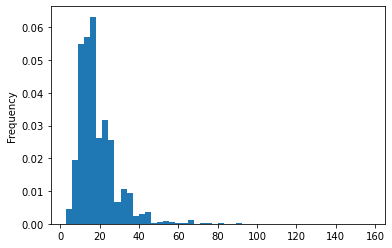

In [1]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline

path = 'C:/kaggle_data/credit_card/'

train = pd.read_csv(path+'train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv(path+'test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submission = pd.read_csv(path+'sample_submission.csv')

data=pd.concat([train, test], axis=0)
data.shape

# 나이 변환
def days_to_age(x):
    return (x*-1)/365
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

# 마이너스 값 변환
def minus(x):
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)

data.loc[(data.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0

data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)

data.loc[data['child_num'] >= 2,'child_num']=2

data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

data.info()

train=data[:len(data)-10000]
test=data[len(data)-10000:]

train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index


nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_X[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

features = [ col for col in train_x.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values

In [9]:
X_test.dtypes

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

In [2]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', 
                                lambda_sparse=0, 
                       
                      )

Device used : cuda


In [3]:
max_epochs = 10
clf.fit(
    X_train=X_train, y_train=y_train,
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.96739 |  0:00:03s
epoch 1  | loss: 0.88293 |  0:00:05s
epoch 2  | loss: 0.87904 |  0:00:07s
epoch 3  | loss: 0.87817 |  0:00:09s
epoch 4  | loss: 0.87433 |  0:00:11s
epoch 5  | loss: 0.87229 |  0:00:13s
epoch 6  | loss: 0.86675 |  0:00:15s
epoch 7  | loss: 0.85068 |  0:00:17s
epoch 8  | loss: 0.80911 |  0:00:19s
epoch 9  | loss: 0.80243 |  0:00:21s


In [4]:
preds_valid = clf.predict_proba(X_valid) 

In [6]:
preds_valid

[array([[0.12888925, 0.23194307, 0.63916767],
        [0.14836337, 0.24453555, 0.6071011 ],
        [0.08267879, 0.1813903 , 0.73593086],
        ...,
        [0.10350421, 0.20922178, 0.68727404],
        [0.19792405, 0.7999865 , 0.00208945],
        [0.19792405, 0.7999865 , 0.00208945]], dtype=float32)]

In [5]:
preds = clf.predict_proba(X_test)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
clf.feature_importances_

array([0.00619394, 0.00576959, 0.08090499, 0.04623143, 0.02449365,
       0.03460251, 0.13866297, 0.01080321, 0.03821061, 0.06909439,
       0.06285745, 0.02037808, 0.04075837, 0.00378588, 0.21078522,
       0.12872638, 0.0132634 , 0.06447791])

In [ ]:
i, j, k = [], [], []
for row in range(10000):
  i.append(preds[0][row][0])
  j.append(preds[0][row][1])
  k.append(preds[0][row][2])

len(i), len(j), len(k)

(10000, 10000, 10000)

In [ ]:
submission['0'] = i
submission['1'] = j
submission['2'] = k
submission.head(10)

,index,0,1,2
0,26457,0.110453,0.352578,0.536969
1,26458,0.253677,0.411024,0.335299
2,26459,0.110948,0.571531,0.317522
3,26460,0.021644,0.179785,0.798571
4,26461,0.009317,0.000071,0.990611
5,26462,0.054142,0.061007,0.884851
6,26463,0.190424,0.782257,0.027318
7,26464,0.017569,0.856357,0.126074
8,26465,0.247234,0.188375,0.564391
9,26466,0.000044,0.013179,0.986777


In [ ]:
submission.to_csv(path+"submisison_tabnet.csv",index=False)

In [ ]:
prediction = pd.read_csv(path+'submisison_tabnet.csv')

In [ ]:
prediction

,index,0,1,2
0,26457,0.110453,0.352578,0.536969
1,26458,0.253677,0.411024,0.335299
2,26459,0.110948,0.571531,0.317522
3,26460,0.021644,0.179785,0.798571
4,26461,0.009317,0.000071,0.990611
...,...,...,...,...
9995,36452,0.206809,0.302276,0.490915
9996,36453,0.021563,0.103430,0.875007
9997,36454,0.000578,0.024714,0.974708
9998,36455,0.023066,0.004329,0.972605
